# Feature engineering

En este notebook se incorporan algunas features extras derivadas de la ubicación de los locales en el espacio

In [363]:
!pip install cenpy
!pip install python-Levenshtein
!pip install osmnx
!pip install hdbscan
!pip install geopandas
!pip install contextily
!pip install pysal 

  Using cached numpy-1.21.4-cp39-cp39-macosx_10_9_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.4 which is incompatible.
  Using cached numpy-1.20.3-cp39-cp39-macosx_10_9_x86_64.whl (16.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is

In [364]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily
import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

%matplotlib inline

## Lectura de datos 

In [365]:
data = pd.read_csv('./data/geo_data.csv',  index_col=[0])

In [366]:
data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...                                       geometry  \
0    1500000  7500.000000  ...  POINT (-6515379.180859259 -4114970.853546773)   
1     125000  2500.000000  ...  POINT (-6515322.519238445 -4111251.604641595)   
2     590000  1425.120773  ...  POINT (-6515319.513612195 -4111882.057282486)   
3     730000  1763.000000  ...   POINT (-6515298.02895047 -4111865.284430326)   
4     550000  1929.000000  ...   POINT (-6515298.02895047 -4111865.284430326)   

     lon_planar    lat_planar                    calle  altura  comunas  \
0 -6.515379e+06 -4.114971e+06        Avenida Rivadavia   11674        9   
1 -6.515323e+06 -4.111252e+06     Avenida Lope de Vega    3500       11   
2 -6.515320e+06 -4.111882e+06  Avenida Francisco Beiró   -9999       10   
3 -6.515298e+06 -4.111865e+06  Avenida Francisco Beiró   -9999       10   
4 -6.515298e+06 -4.111865e+06  Avenida Francisco Beiró   -9999       10   

        barrios  densidad_poblacional  densidad_viviendas         distritos  
0       LINIERS           9162.535077         3428.444997  NO CARACTERIZADO  
1  VILLA DEVOTO           8847.779056         3215.839159  NO CARACTERIZADO  
2    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  
3    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  
4    VILLA REAL           8773.980909         3209.091367  NO CARACTERIZADO  

[5 rows x 26 columns]

In [367]:
data['geometry'] = data['geometry'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, crs='epsg:3857').to_crs(epsg=4326)

In [368]:
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...                     geometry    lon_planar  \
0    1500000  7500.000000  ...  POINT (-58.52865 -34.63930) -6.515379e+06   
1     125000  2500.000000  ...  POINT (-58.52814 -34.61181) -6.515323e+06   
2     590000  1425.120773  ...  POINT (-58.52811 -34.61647) -6.515320e+06   
3     730000  1763.000000  ...  POINT (-58.52792 -34.61634) -6.515298e+06   
4     550000  1929.000000  ...  POINT (-58.52792 -34.61634) -6.515298e+06   

     lat_planar                    calle  altura  comunas       barrios  \
0 -4.114971e+06        Avenida Rivadavia   11674        9       LINIERS   
1 -4.111252e+06     Avenida Lope de Vega    3500       11  VILLA DEVOTO   
2 -4.111882e+06  Avenida Francisco Beiró   -9999       10    VILLA REAL   
3 -4.111865e+06  Avenida Francisco Beiró   -9999       10    VILLA REAL   
4 -4.111865e+06  Avenida Francisco Beiró   -9999       10    VILLA REAL   

   densidad_poblacional  densidad_viviendas         distritos  
0           9162.535077         3428.444997  NO CARACTERIZADO  
1           8847.779056         3215.839159  NO CARACTERIZADO  
2           8773.980909         3209.091367  NO CARACTERIZADO  
3           8773.980909         3209.091367  NO CARACTERIZADO  
4           8773.980909         3209.091367  NO CARACTERIZADO  

[5 rows x 26 columns]

In [369]:
geo_data.shape

(3670, 26)

## Features no espaciales

### Avenidas

Crear un feature que define si el local se encuentra sobre una avenida o no

In [370]:
geo_data.loc[:, 'SobreAvenida'] = "0"
geo_data.loc[geo_data['calle'].str.contains("Avenida"), 'SobreAvenida'] = "1"

In [371]:
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...    lon_planar    lat_planar  \
0    1500000  7500.000000  ... -6.515379e+06 -4.114971e+06   
1     125000  2500.000000  ... -6.515323e+06 -4.111252e+06   
2     590000  1425.120773  ... -6.515320e+06 -4.111882e+06   
3     730000  1763.000000  ... -6.515298e+06 -4.111865e+06   
4     550000  1929.000000  ... -6.515298e+06 -4.111865e+06   

                     calle  altura  comunas       barrios  \
0        Avenida Rivadavia   11674        9       LINIERS   
1     Avenida Lope de Vega    3500       11  VILLA DEVOTO   
2  Avenida Francisco Beiró   -9999       10    VILLA REAL   
3  Avenida Francisco Beiró   -9999       10    VILLA REAL   
4  Avenida Francisco Beiró   -9999       10    VILLA REAL   

  densidad_poblacional  densidad_viviendas         distritos SobreAvenida  
0          9162.535077         3428.444997  NO CARACTERIZADO            1  
1          8847.779056         3215.839159  NO CARACTERIZADO            1  
2          8773.980909         3209.091367  NO CARACTERIZADO            1  
3          8773.980909         3209.091367  NO CARACTERIZADO            1  
4          8773.980909         3209.091367  NO CARACTERIZADO            1  

[5 rows x 27 columns]

Text(0.5, 1.0, 'Boxplot')

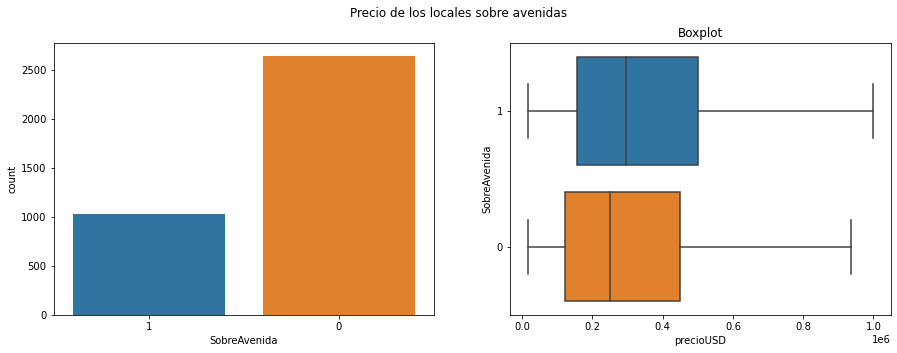

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales sobre avenidas')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['SobreAvenida'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['SobreAvenida'], showfliers=False)
axes[1].set_title("Boxplot")

### Antiguedad

In [373]:
# Agregar variable binaria que define si los locales son a estrenar o no
geo_data['antig'].nunique()
estrenar = []
for i in geo_data["antig"]:
  if i == 0:
    estrenar.append("1")
  else:
    estrenar.append("0")

#Se agrega variable Aestrenar al data frame
geo_data["Aestrenar"] = estrenar

Text(0.5, 1.0, 'Boxplot')

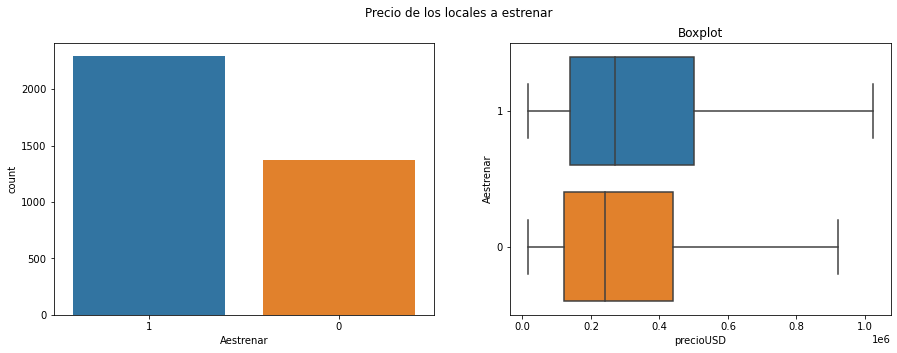

In [374]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales a estrenar')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['Aestrenar'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['Aestrenar'], showfliers=False)
axes[1].set_title("Boxplot")

De la variable "antig" se generó una nueva variable "Aestrenar" donde los locales comerciales a esternar adquieren el valor 1 y el resto de locales el valor 0. Se observa una mayor cantidad de locales comerciales a estrenar (2318) que locales usados (1393).

### Cantidad de ambientes

#### Monoambiente

In [375]:
# Se agrega una variable binaria que considera si el local es un monoambiente o no.
ambis = []
for i in geo_data["ambientes"]:
    if i == 0:
        ambis.append("1")
    else:
        ambis.append("0")

#Se agrega variable Aestrenar al data frame
geo_data["monoambiente"] = ambis

Text(0.5, 1.0, 'Boxplot')

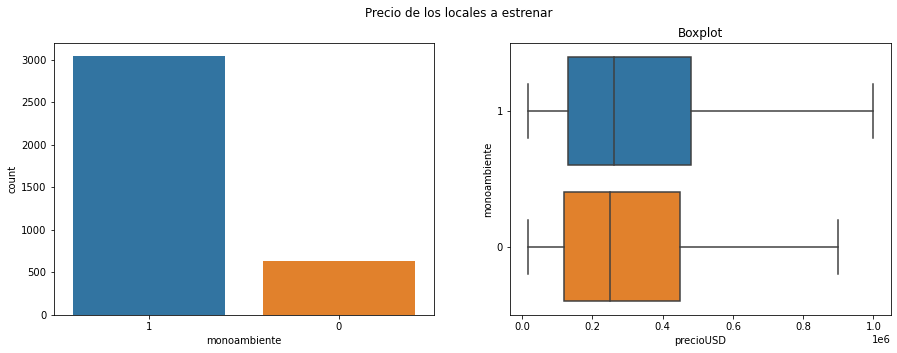

In [376]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precio de los locales a estrenar')

# Histograma
sns.countplot(ax=axes[0], x = geo_data['monoambiente'])

# Boxplot
sns.boxplot(ax=axes[1], x = geo_data['precioUSD'],  y = geo_data['monoambiente'], showfliers=False)
axes[1].set_title("Boxplot")

#### Clasificacion ambientes

In [377]:
geo_data.loc[geo_data.ambientes >= 5, 'clas_ambientes'] = 5
geo_data.loc[geo_data.ambientes < 5, 'clas_ambientes'] = geo_data.ambientes
geo_data['clas_ambientes'] = geo_data.clas_ambientes.astype(int).astype(str)
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  altura  comunas       barrios  \
0    1500000  7500.000000  ...   11674        9       LINIERS   
1     125000  2500.000000  ...    3500       11  VILLA DEVOTO   
2     590000  1425.120773  ...   -9999       10    VILLA REAL   
3     730000  1763.000000  ...   -9999       10    VILLA REAL   
4     550000  1929.000000  ...   -9999       10    VILLA REAL   

   densidad_poblacional  densidad_viviendas         distritos SobreAvenida  \
0           9162.535077         3428.444997  NO CARACTERIZADO            1   
1           8847.779056         3215.839159  NO CARACTERIZADO            1   
2           8773.980909         3209.091367  NO CARACTERIZADO            1   
3           8773.980909         3209.091367  NO CARACTERIZADO            1   
4           8773.980909         3209.091367  NO CARACTERIZADO            1   

   Aestrenar  monoambiente clas_ambientes  
0          1             1              0  
1          0             1              0  
2          0             1              0  
3          0             1              0  
4          0             1              0  

[5 rows x 30 columns]

#### Clasificacion baños

In [378]:
geo_data.loc[geo_data.banios >= 4, 'clas_banios'] = 4
geo_data.loc[geo_data.banios < 4, 'clas_banios'] = geo_data.banios
geo_data['clas_banios'] = geo_data.clas_banios.astype(int).astype(str)
geo_data.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  comunas       barrios  densidad_poblacional  \
0    1500000  7500.000000  ...        9       LINIERS           9162.535077   
1     125000  2500.000000  ...       11  VILLA DEVOTO           8847.779056   
2     590000  1425.120773  ...       10    VILLA REAL           8773.980909   
3     730000  1763.000000  ...       10    VILLA REAL           8773.980909   
4     550000  1929.000000  ...       10    VILLA REAL           8773.980909   

   densidad_viviendas         distritos  SobreAvenida Aestrenar  monoambiente  \
0         3428.444997  NO CARACTERIZADO             1         1             1   
1         3215.839159  NO CARACTERIZADO             1         0             1   
2         3209.091367  NO CARACTERIZADO             1         0             1   
3         3209.091367  NO CARACTERIZADO             1         0             1   
4         3209.091367  NO CARACTERIZADO             1         0             1   

   clas_ambientes clas_banios  
0               0           0  
1               0           1  
2               0           2  
3               0           2  
4               0           1  

[5 rows x 31 columns]

## Features espaciales

In [379]:
geo_data_planar = geo_data.to_crs(epsg=3857)

Se crea una objeto que posee los límites de la capa de locales. Es equivalente a la extensión de la capa pero considerando la distribución de los locales en la ciudad. No es solamente un bounding box.

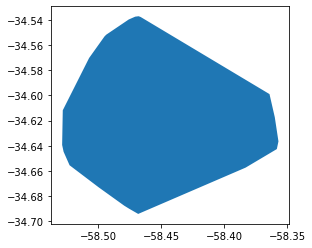

In [380]:
geo_data_ch = geo_data.unary_union.convex_hull
gpd.GeoSeries([geo_data_ch]).plot();

In [381]:
# Agregar buffer de 500 para las superpocisiones
geo_data_planar['buffer_500m'] = geo_data_planar.buffer(500)

### Gastronomia

Se extraen la cantidad de locales gastronómicos que se encuentran en un buffer alrededor de cada local.

In [382]:
%%time
pois_gastronomia = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['restaurant', 'bar', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream', 'pub']}
).reset_index()[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

CPU times: user 609 ms, sys: 52.6 ms, total: 662 ms
Wall time: 1.04 s


In [383]:
pois_gastronomia.groupby('amenity').amenity.count()

amenity
bar            379
biergarten       5
cafe          1027
fast_food      729
food_court       1
ice_cream      346
pub            101
restaurant    2184
Name: amenity, dtype: int64

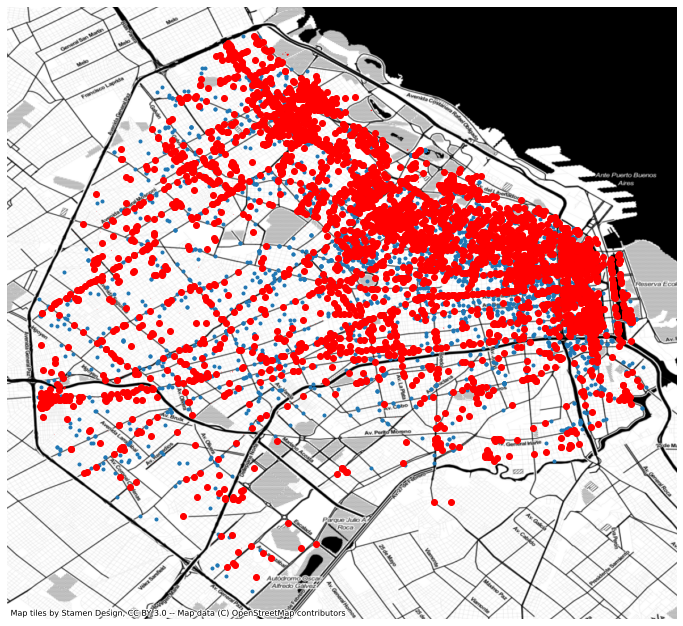

In [384]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_gastronomia.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [385]:
# Proyectar datos para realizar geoprocesos
pois_gastronomia_planar = pois_gastronomia.to_crs(epsg=3857)

In [386]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_gastronomia_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [387]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'poi_count_gastronomia'
)
# Evaluar resultados
poi_count.head()

poi_count_gastronomia
id                       
1                      52
2                       6
3                       4
4                       7
5                       7

In [388]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"poi_count_gastronomia": 0})

In [389]:
geo_data.shape

(3670, 31)

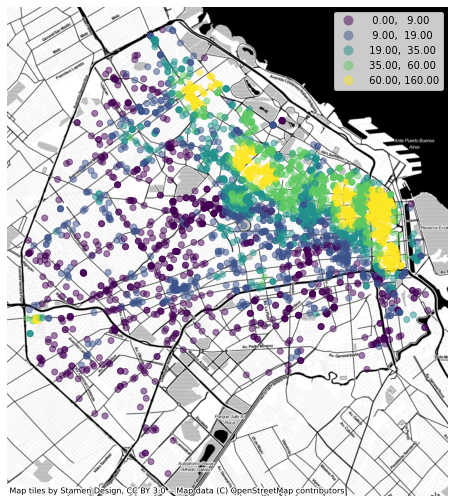

In [390]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="poi_count_gastronomia",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Educación

In [391]:
%%time
pois_education = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['college', 'kindergarten', 'library', 'language_school', 'school', 'university']}
).reset_index()[["osmid", "amenity", "name", "geometry"]]

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


CPU times: user 541 ms, sys: 30.1 ms, total: 571 ms
Wall time: 730 ms


In [392]:
pois_education.groupby('amenity').amenity.count()

amenity
college             369
kindergarten        781
language_school      11
library              85
school             1669
university           93
Name: amenity, dtype: int64

In [393]:
pois_education[:1]

osmid       amenity                                               name  \
0  331525623  kindergarten  Jardín de Infantes Nucleado D (EPCjc 08/18°) [...   

                      geometry  
0  POINT (-58.49620 -34.63594)

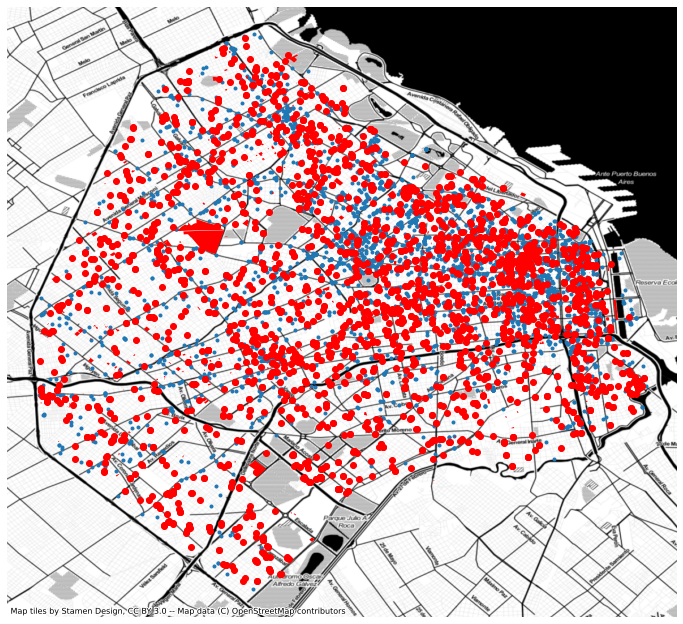

In [394]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_education.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [395]:
pois_education_planar = pois_education.to_crs(epsg=3857)

In [396]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_education_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    op="within"
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [397]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'poi_count_educacion'
)
# Evaluar resultados
poi_count.head()

poi_count_educacion
id                     
1                    16
3                     3
4                     3
5                     3
6                    12

In [398]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"poi_count_educacion": 0})

In [399]:
geo_data_planar.shape

(3670, 34)

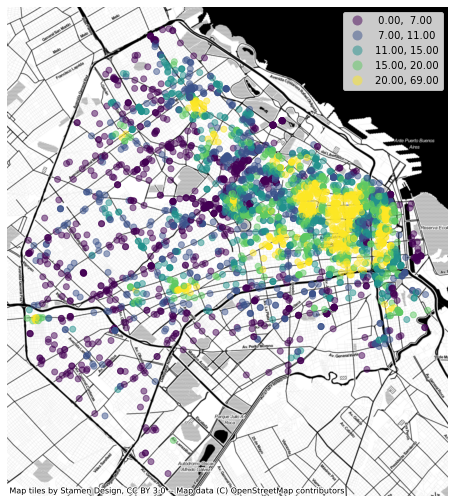

In [400]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="poi_count_educacion",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Avenidas

In [401]:
%%time
pois_roads = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"highway": ['trunk', 'primary', 'secondary']}
).reset_index()#[["osmid", "amenity", "name", "cuisine", "name", "geometry"]]

CPU times: user 1.18 s, sys: 82.4 ms, total: 1.26 s
Wall time: 1.29 s


In [402]:
pois_roads.head()

element_type    osmid    highway  \
0          way  8093354  secondary   
1          way  9937027  secondary   
2          way  9937842  secondary   
3          way  9967926  secondary   
4          way  9971280  secondary   

                                            geometry  bus  \
0  LINESTRING (-58.46323 -34.57510, -58.46268 -34...  NaN   
1  LINESTRING (-58.46497 -34.60275, -58.46552 -34...  NaN   
2  LINESTRING (-58.41052 -34.63507, -58.40934 -34...  NaN   
3  LINESTRING (-58.46205 -34.58513, -58.46100 -34...  NaN   
4  LINESTRING (-58.47084 -34.58747, -58.47022 -34...  NaN   

                                      name source maxspeed  surface  \
0                           Avenida Forest    NaN       60  asphalt   
1  Avenida Teniente General Donato Álvarez    NaN       60  asphalt   
2                           Avenida Brasil    NaN       60  asphalt   
3                      Avenida Triunvirato    NaN       60     sett   
4                        Avenida del Campo    NaN       20  asphalt   

        hazard  ... source:oneway motor_vehicle:conditional  \
0          NaN  ...           NaN                       NaN   
1          NaN  ...           NaN                       NaN   
2          NaN  ...           NaN                       NaN   
3          NaN  ...           NaN                       NaN   
4  school_zone  ...           NaN                       NaN   

  lanes:psv:conditional access:lanes parking:lane:both lanes:bus loc_name  \
0                   NaN          NaN               NaN       NaN      NaN   
1                   NaN          NaN               NaN       NaN      NaN   
2                   NaN          NaN               NaN       NaN      NaN   
3                   NaN          NaN               NaN       NaN      NaN   
4                   NaN          NaN               NaN       NaN      NaN   

  emergency bus_bay destination  
0       NaN     NaN         NaN  
1       NaN     NaN         NaN  
2       NaN     NaN         NaN  
3       NaN     NaN         NaN  
4       NaN     NaN         NaN  

[5 rows x 98 columns]

In [403]:
pois_roads.groupby('highway').highway.count()

highway
primary       859
secondary    3381
trunk          52
Name: highway, dtype: int64

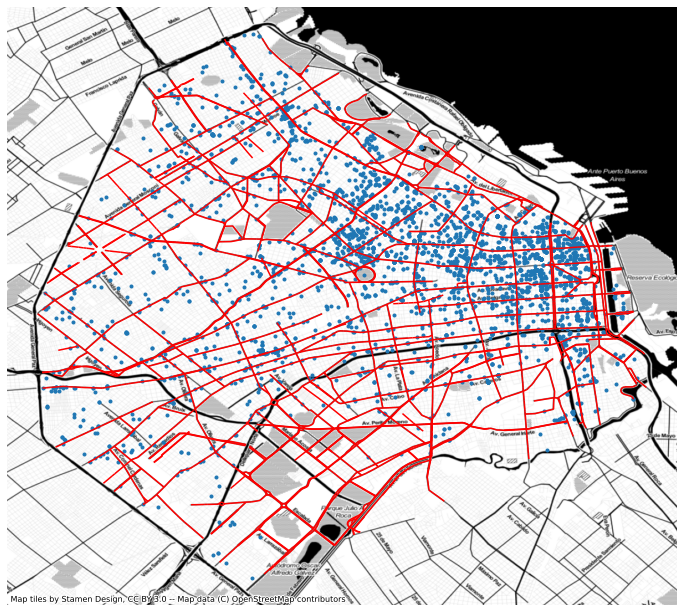

In [404]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_roads.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [405]:
pois_roads_planar = pois_roads.to_crs(epsg=3857)

In [406]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_roads_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [407]:
# Group POIs by Airbnb ID (`id`)
poi_count = joined.groupby(
    "id"
# Keep only POI id column (`osmid`)
)[
    "osmid"
# Count POIs by Airbnb + convert Series into DataFrame
].count().to_frame(
    'poi_count_roads'
)
# Print top of the table
poi_count.head()

poi_count_roads
id                 
1                 7
2                10
3                 9
4                10
5                10

In [408]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"poi_count_roads": 0})

In [409]:
geo_data_planar.shape

(3670, 35)

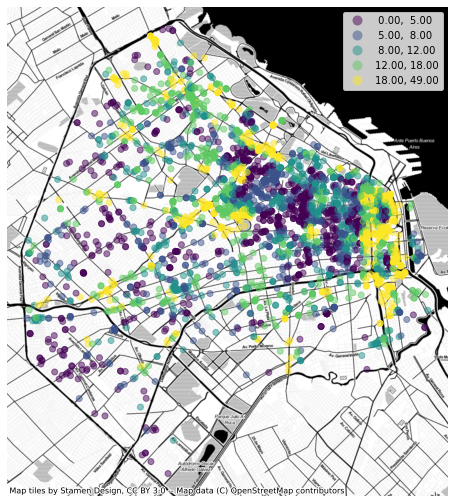

In [410]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="poi_count_roads",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Salud

In [411]:
%%time
pois_salud = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"amenity": ['baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home', '	pharmacy', 'social_facility', '	veterinary']}
).reset_index()[["osmid", "amenity", "name", "geometry"]]

CPU times: user 240 ms, sys: 13.2 ms, total: 253 ms
Wall time: 376 ms


In [412]:
pois_salud.groupby('amenity').amenity.count()

amenity
clinic             223
dentist             97
doctors             62
hospital           113
nursing_home         1
social_facility    113
Name: amenity, dtype: int64

In [413]:
pois_salud[:1]

osmid   amenity                     name                     geometry
0  680002885  hospital  Clinica Suizo Argentina  POINT (-58.40187 -34.59387)

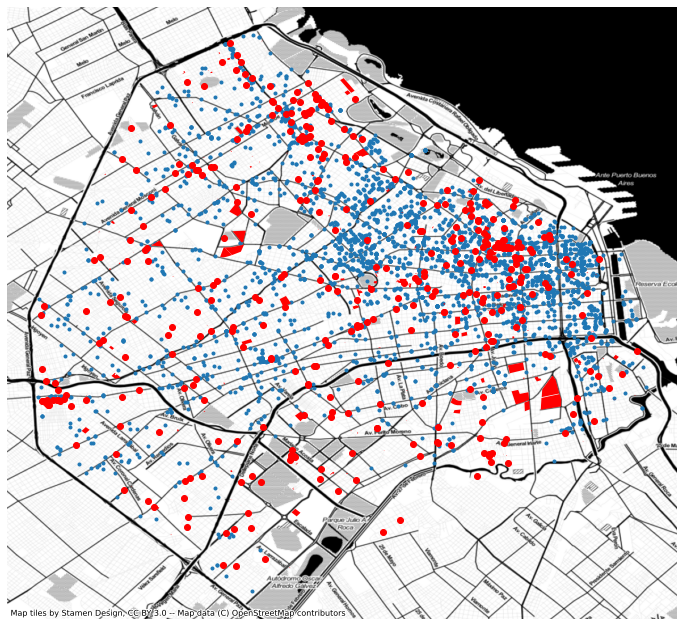

In [414]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_salud.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [415]:
pois_salud_planar = pois_salud.to_crs(epsg=3857)

In [416]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_salud_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [417]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'poi_count_salud'
)
# Evaluar resultados
poi_count.head()

poi_count_salud
id                 
1                 6
2                 1
3                 2
4                 2
5                 2

In [418]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"poi_count_salud": 0})

In [419]:
geo_data_planar.shape

(3670, 36)

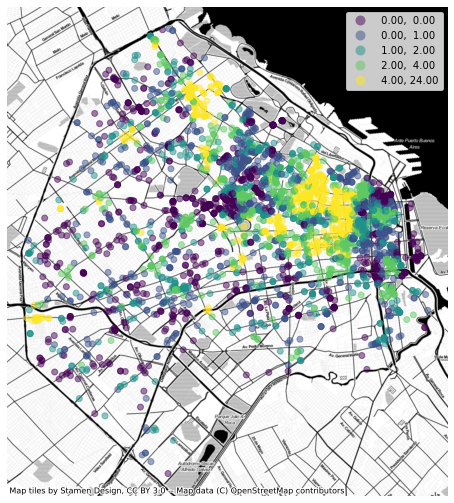

In [420]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="poi_count_salud",
    scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

### Transporte

In [421]:
%%time
pois_transporte = osmnx.geometries_from_polygon(
    geo_data_ch, tags={"public_transport": ['station', 'stop_area']}
).reset_index()[["osmid", "public_transport", "name", "geometry"]]

CPU times: user 643 ms, sys: 31.6 ms, total: 675 ms
Wall time: 702 ms


In [422]:
pois_transporte.groupby('public_transport').public_transport.count()

public_transport
station    149
Name: public_transport, dtype: int64

In [423]:
pois_transporte[:1]

osmid public_transport              name                     geometry
0  256241985          station  Avenida La Plata  POINT (-58.42640 -34.62697)

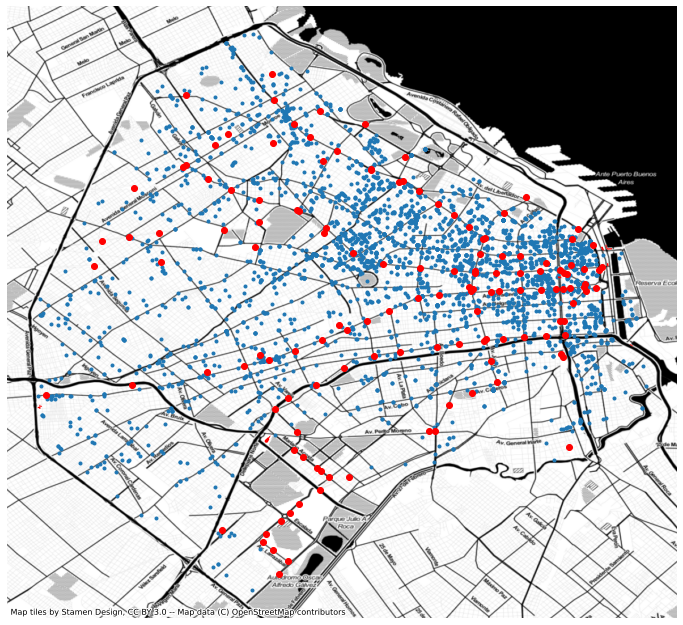

In [424]:
# Set up figure and axis
f,ax = plt.subplots(1,figsize=(12, 12))
# Plot AirBnb properties
geo_data.plot(ax=ax, marker='.')
# Plot POIs in red
pois_transporte.plot(ax=ax, color='r')
# Add Stamen's Toner basemap
contextily.add_basemap(
    ax, 
    crs=geo_data.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off()
# Display
plt.show()

In [425]:
pois_transporte_planar = pois_transporte.to_crs(epsg=3857)

In [426]:
# Spatial join, appending attributes from right table to left one
joined = gpd.sjoin(
    # Right table - POIs
    pois_transporte_planar,
    # Left table - Airbnb with the geometry reset from the original
    # points to the 500m buffer and selecting only `id` and
    # `buffer_500m` column
    geo_data_planar.set_geometry('buffer_500m')[['id', 'buffer_500m']],
    # Operation (spatial predicate) to use for the spatial join (`within`)
    predicate="within"
)

In [427]:
# Agrupar los POI por id del local (`id`)
poi_count = joined.groupby(
    "id"
# Mantener solo la variable id del POI (`osmid`)
)[
    "osmid"
# Contar los POI por local y convertir la serie en un data frame
].count().to_frame(
    'poi_count_transporte'
)
# Evaluar resultados
poi_count.head()

poi_count_transporte
id                      
1                      2
6                      1
8                      1
9                      1
10                     1

In [428]:
geo_data_planar = geo_data_planar.merge(
    poi_count, left_on='id', right_index=True, how = 'left'
).fillna({"poi_count_transporte": 0})

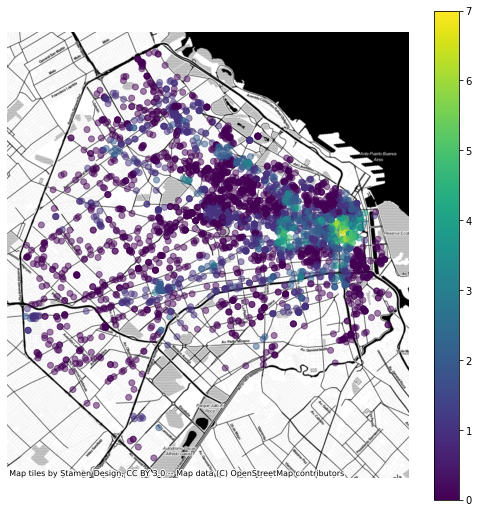

In [429]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot quantile map of No. of POIs for every Airbnb
geo_data_planar.plot(
    column="poi_count_transporte",
    #scheme="quantiles",
    alpha=0.5,
    legend=True,
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.Stamen.Toner
)
# Remove axes
ax.set_axis_off();

In [430]:
geo_data_planar.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  Aestrenar  monoambiente  clas_ambientes  \
0    1500000  7500.000000  ...          1             1               0   
1     125000  2500.000000  ...          0             1               0   
2     590000  1425.120773  ...          0             1               0   
3     730000  1763.000000  ...          0             1               0   
4     550000  1929.000000  ...          0             1               0   

   clas_banios                                        buffer_500m  \
0            0  POLYGON ((-6514879.181 -4114970.854, -6514881....   
1            1  POLYGON ((-6514822.519 -4111251.605, -6514824....   
2            2  POLYGON ((-6514819.514 -4111882.057, -6514821....   
3            2  POLYGON ((-6514798.029 -4111865.284, -6514800....   
4            1  POLYGON ((-6514798.029 -4111865.284, -6514800....   

   poi_count_gastronomia poi_count_educacion  poi_count_roads  \
0                   52.0                16.0              7.0   
1                    6.0                 0.0             10.0   
2                    4.0                 3.0              9.0   
3                    7.0                 3.0             10.0   
4                    7.0                 3.0             10.0   

   poi_count_salud poi_count_transporte  
0              6.0                  2.0  
1              1.0                  0.0  
2              2.0                  0.0  
3              2.0                  0.0  
4              2.0                  0.0  

[5 rows x 37 columns]

In [431]:
geo_data_planar.shape

(3670, 37)

### Map Synthesis

In [432]:
from libpysal import weights

Just like in map matching, you can use spatial summary features in map synthesis to make create better models. One approach involves constructing spatial summary measures of your training data. This is done in the same manner as in map matching, except we now refer only to the data on hand. Thus, we may want to determine whether nearby shops are "competing" with each shop for the same buyer. We might do this by finding the distance to the nearest shop on sale with the same surface, number of stances, etc, since two nearby listings with similar characteristics likely will compete with one another for potential buyers. 

#### Counting neighbors

A useful metric to characterise an observation in your data through geography is whether it is surrounded by other observations or not. This question is another area of geographic data science where spatial weights matrices are useful.

If we define to be "surrounded by other observations" as in "having many neighbors", this translates into the cardinalities of a spatial weights matrix (ie. the number of neighbors recorded in the matrix for each observation).

For example, we can "engineer a feature" that contains the number of empty properties each property has within 500 metres by constructing a distance band object:

In [433]:
# Build distance band spatial weights matrix
d500_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=500, silence_warnings=True
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [434]:
card = pd.Series(d500_w.cardinalities)

The `card` feature we have built will pick up areas of higher concentration of commercial properties with higher values, as we can see in the map below.

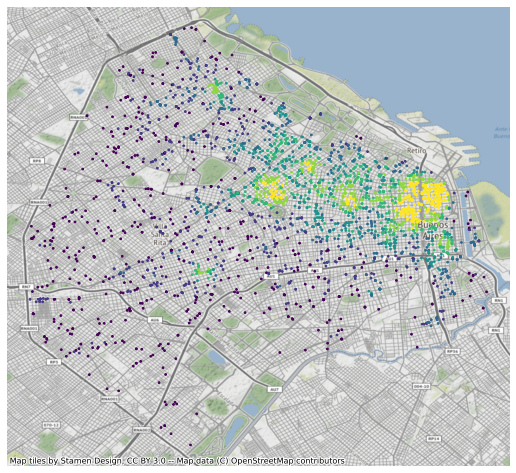

In [435]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Append cardinalities to main Airbnb geo-table
geo_data.assign(
    card=card
# Plot cardinality quantile choropleth
).plot('card', scheme='quantiles', k=7, markersize=3, ax=ax)
# Add basemap
contextily.add_basemap(ax, crs=geo_data.crs)
# Remove axes
ax.set_axis_off();

In [436]:
geo_data_planar['cardinality'] = card

#### Distance buffers within a single table

If what we are interested in is finding the average number of rooms around each shop, we might do this with using a row-standardised version of the `DistanceBand` weight object we have just built, which considers shops as "neighbors" if they are within the distance threshold, and computing the spatial lag of the number of rooms.

In [437]:
geo_data_planar['ambientes'] = geo_data[['ambientes']]

In [438]:
# Row standardise
d500_w.transform = 'r'
# Compute spatial lag of surface of each shop
local_average_surface = weights.lag_spatial(
    d500_w, geo_data_planar[['ambientes']].values
)

While related, these features contain quite distinct pieces of information, and both may prove useful in modeling: 

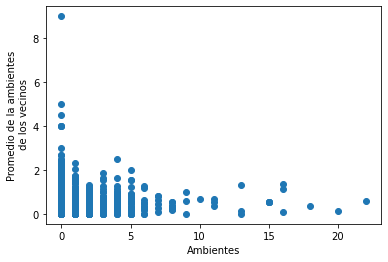

In [439]:
plt.scatter(geo_data_planar[['ambientes']].values, local_average_surface)
plt.xlabel("Ambientes")
plt.ylabel("Promedio de la ambientes\n de los vecinos");

If we were instead interested in the most common number of bedrooms, rather than the average, we could use the `lag_categorical` function, which will consider each value as a category and return the most common value in each neighbor set:

In [440]:
local_mode = weights.lag_categorical(
    d500_w, geo_data_planar[['ambientes']].values
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/spatial_lag.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_labels = np.zeros(y.shape, dtype=np.int)
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(

Since we are now treating the number of bedrooms as a discrete feature, we can use a `crosstab` from `pandas` to examine the relationship between a listing and the typical size of listings nearby:

In [441]:
crosstab = pd.crosstab(
    geo_data_planar.ambientes, local_mode.flatten()
)
crosstab.columns.name = "nearby"
crosstab

nearby        0   1  2  3  4  5  6  9
ambientes                            
0          3003  28  5  0  4  1  0  1
1           350  23  0  2  0  0  0  0
2            82   2  5  0  0  0  0  0
3            51   3  0  2  1  0  0  0
4            30   3  0  0  0  1  0  0
5            27   0  0  0  0  0  0  0
6            10   0  0  0  0  0  1  0
7             6   0  0  0  0  0  0  0
8             9   0  0  0  0  0  0  0
9             3   0  0  0  0  0  0  0
10            1   0  0  0  0  0  0  0
11            3   0  0  0  0  0  0  0
13            3   0  0  0  0  0  0  0
15            4   0  0  0  0  0  0  0
16            3   0  0  0  0  0  0  0
18            1   0  0  0  0  0  0  0
20            1   0  0  0  0  0  0  0
22            1   0  0  0  0  0  0  0

From the table we can see the most common case (N=1816) is properties with just a single room surrounded mostly by other properties with also only one room. Similarly we also find out, for example, that the two properties with ten bedrooms in the dataset are surrounded by properties with mostly two bedrooms. The remaining cells in the table can be interpreted in a similar fashion.

If more complicated statistics are required, it can help to re-express the construction of summary statistics as a *reduction* of the *adjacency list* representation of our weights, as done in [Chapter 3](03_spatial_data). To recap, the *adjacency list* is a `pandas.DataFrame` where each row contains a single link in our graph. It contains the identifier for some `focal` observation, the identifier for some `neighbor` observation, and a value for the `weight` of the link that connects the `focal` and `neighbor`:

In [442]:
adjlist = d500_w.to_adjlist()

In [443]:
adjlist.head()

focal  neighbor  weight
0      0         5   0.125
1      0        10   0.125
2      0        13   0.125
3      0        14   0.125
4      0        15   0.125

If we had the values for each for the neighbors in this adjacency list table, then we could use a `groupby()` to summarize the values of observations connected to a given focal observation. This merge can be done directly with the original data, linking the `neighbor` key in the adjacency list back to that observation in our source table: 

In [444]:
adjlist = adjlist.merge(
    geo_data_planar[['ambientes']], 
    left_on='neighbor', 
    right_index=True, 
    how='left'
)
adjlist.head()

focal  neighbor  weight  ambientes
0      0         5   0.125          0
1      0        10   0.125          0
2      0        13   0.125          0
3      0        14   0.125          6
4      0        15   0.125          0

Now, we need only to group the adjacency list by the focal observation and summarize the `bedrooms` column to obtain the median number of bedrooms for each `focal` observation. 

In [445]:
adjlist.groupby("focal").ambientes.median()

focal
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3705    0.0
3706    0.0
3707    1.0
3708    0.0
3709    0.0
Name: ambientes, Length: 3629, dtype: float64

Since the mean and/or mode are the most commonly-used measures of central tendency, the `lag_spatial` and `lag_categorical` functions cover many of the required uses in practice. 

#### "Ring" buffer features

Sometimes, analysts might want to use multiple "bands" of buffer features. This requires that we build summaries of the observations that fall *only within* a given range of distances, such as the typical size of houses that are further than 500m, but still within one kilometer. This kind of "ring buffer", or annulus, is a common request in spatial analysis, and can be done in substantially the same way as before by increasing the `threshold` in a `DistanceBand` weight.  

We can use our 500m weights from before to build the average again:

##### Band buffer

In [446]:
average_within_500 = weights.lag_spatial(
    d500_w, geo_data_planar[['m2total']].values
)

In [447]:
d1k_w = weights.DistanceBand.from_dataframe(
    geo_data_planar, threshold=1000, silence_warnings=True
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


In [448]:
d1k_exclusive = weights.set_operations.w_difference(
    d1k_w, d500_w, constrained=False
)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
 There are 18 islands with ids: 142, 176, 391, 392, 403, 440, 1309, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 3406, 3417, 3686.
  warnings.warn(message)


In [449]:
d1k_exclusive.transform = 'r'
average_500m_to_1k = weights.lag_spatial(
    d1k_exclusive, geo_data_planar[['m2total']].values
)

('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 176, ' is an island (no neighbors)')
('WARNING: ', 391, ' is an island (no neighbors)')
('WARNING: ', 392, ' is an island (no neighbors)')
('WARNING: ', 403, ' is an island (no neighbors)')
('WARNING: ', 440, ' is an island (no neighbors)')
('WARNING: ', 1309, ' is an island (no neighbors)')
('WARNING: ', 1777, ' is an island (no neighbors)')
('WARNING: ', 1778, ' is an island (no neighbors)')
('WARNING: ', 1779, ' is an island (no neighbors)')
('WARNING: ', 1780, ' is an island (no neighbors)')
('WARNING: ', 1781, ' is an island (no neighbors)')
('WARNING: ', 1782, ' is an island (no neighbors)')
('WARNING: ', 1783, ' is an island (no neighbors)')
('WARNING: ', 1784, ' is an island (no neighbors)')
('WARNING: ', 3406, ' is an island (no neighbors)')
('WARNING: ', 3417, ' is an island (no neighbors)')
('WARNING: ', 3686, ' is an island (no neighbors)')


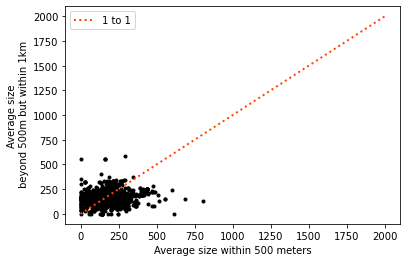

In [450]:
# Plot scatter
plt.scatter(
    average_within_500,
    average_500m_to_1k,
    color='k', marker='.'
)
# Rename horizontal axis
plt.xlabel("Average size within 500 meters")
# Rename vertical axis
plt.ylabel("Average size\n beyond 500m but within 1km")
# Plot line of 45 degrees
plt.plot(
    [0,2000],
    [0,2000], 
    color='orangered', 
    linestyle=':', 
    linewidth=2, 
    label='1 to 1'
)
# Add legend
plt.legend();

In [451]:
geo_data_planar['m2total_buffer_500'] = average_within_500
geo_data_planar['m2total_buffer_1000'] = average_500m_to_1k

##### Clustering

In [452]:
from hdbscan import HDBSCAN

In [453]:
coordinates = numpy.column_stack(
    (geo_data_planar.geometry.x, geo_data_planar.geometry.y)
)

In [454]:
labels = HDBSCAN(min_cluster_size = 20).fit(coordinates).labels_

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

In [455]:
hulls = geo_data_planar[['geometry']].dissolve(by=labels).convex_hull

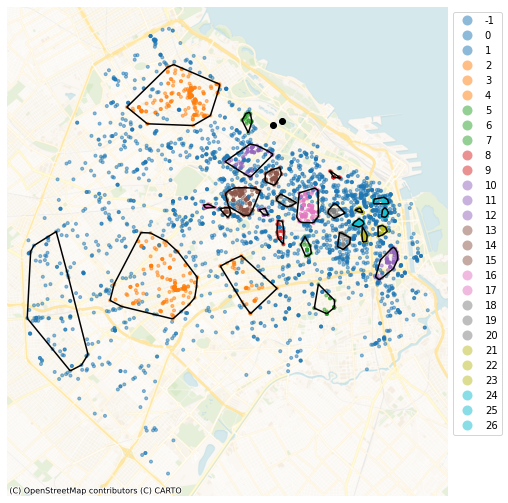

In [456]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot individual Airbnb locations
geo_data_planar.plot(
    # Colour by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax, 
    # Use circle as marker
    marker='.',
    # Position legend outside the map
    legend_kwds={'bbox_to_anchor': (1,1)}
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color='k', ax=ax)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=geo_data_planar.crs.to_string(), 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
# Remove axes
ax.set_axis_off();

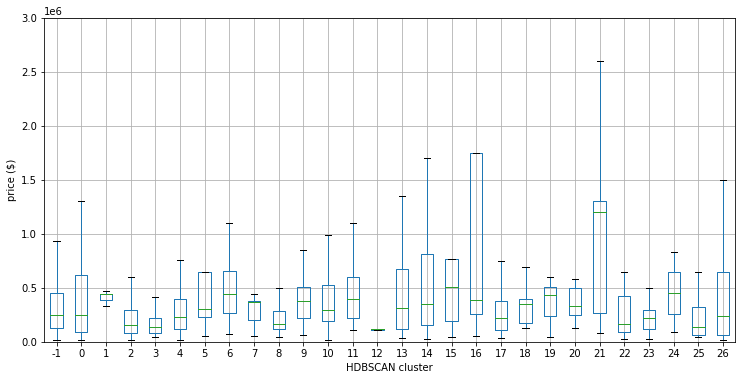

In [457]:
# Set up figure
f = plt.figure(figsize=(12,6))
# Add box plots of price by HDBSCAN cluster
ax = geo_data_planar.boxplot(
    # Plot distribution of 'price'
    "precioUSD", 
    # Group by cluster label, generating one box plot/cluster
    by=labels, 
    # Do not display individual outlier observations
    flierprops=dict(marker=None), 
    # Draw visualisation on the current axis (inside `f`)
    ax=plt.gca()
)
# Set label for horizontal axis
ax.set_xlabel("HDBSCAN cluster")
# Set labels for vertical axis
ax.set_ylabel("price ($)")

# Remove default figure title
plt.gcf().suptitle(None)
# Remove default axis title
ax.set_title(None)
# Re-adjust vertical value range for easier legibility
ax.set_ylim(0,3000000);

In [458]:
geo_data_planar['clusters'] = labels

In [459]:
geo_data_planar.head()

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0   1      0      200    200          0       0 -34.639300 -58.528647   
1   2     30       50     50          0       1 -34.611807 -58.528138   
2   3     30      414    414          0       2 -34.616468 -58.528111   
3   4     35      414    414          0       2 -34.616344 -58.527918   
4   5     35      285    285          0       1 -34.616344 -58.527918   

   precioUSD  m2precioUSD  ...  \
0    1500000  7500.000000  ...   
1     125000  2500.000000  ...   
2     590000  1425.120773  ...   
3     730000  1763.000000  ...   
4     550000  1929.000000  ...   

                                         buffer_500m  poi_count_gastronomia  \
0  POLYGON ((-6514879.181 -4114970.854, -6514881....                   52.0   
1  POLYGON ((-6514822.519 -4111251.605, -6514824....                    6.0   
2  POLYGON ((-6514819.514 -4111882.057, -6514821....                    4.0   
3  POLYGON ((-6514798.029 -4111865.284, -6514800....                    7.0   
4  POLYGON ((-6514798.029 -4111865.284, -6514800....                    7.0   

   poi_count_educacion  poi_count_roads  poi_count_salud  \
0                 16.0              7.0              6.0   
1                  0.0             10.0              1.0   
2                  3.0              9.0              2.0   
3                  3.0             10.0              2.0   
4                  3.0             10.0              2.0   

   poi_count_transporte cardinality  m2total_buffer_500  m2total_buffer_1000  \
0                   2.0           8          126.750000           321.222222   
1                   0.0           1           50.000000           179.000000   
2                   0.0           6          207.666667           231.111111   
3                   0.0           5          192.200000           231.111111   
4                   0.0           5          192.200000           231.111111   

  clusters  
0        0  
1       -1  
2       -1  
3       -1  
4       -1  

[5 rows x 41 columns]

In [460]:
geo_data_planar.columns

Index(['id', 'antig', 'm2total', 'm2cub', 'ambientes', 'banios', 'latitud',
       'longitud', 'precioUSD', 'm2precioUSD', 'comisaria_dista',
       'obelisco_dista', 'nrobos', 'sup_espacio_verde', 'count_gastronomia',
       'count_culturales', 'geometry', 'lon_planar', 'lat_planar', 'calle',
       'altura', 'comunas', 'barrios', 'densidad_poblacional',
       'densidad_viviendas', 'distritos', 'SobreAvenida', 'Aestrenar',
       'monoambiente', 'clas_ambientes', 'clas_banios', 'buffer_500m',
       'poi_count_gastronomia', 'poi_count_educacion', 'poi_count_roads',
       'poi_count_salud', 'poi_count_transporte', 'cardinality',
       'm2total_buffer_500', 'm2total_buffer_1000', 'clusters'],
      dtype='object')

In [461]:
geo_data_planar = geo_data_planar[['id', 'antig', 'm2total', 'm2cub', 'ambientes', 'banios', 'precioUSD', 'm2precioUSD', 'comisaria_dista', 
                'obelisco_dista', 'nrobos', 'sup_espacio_verde', 'count_gastronomia', 'lon_planar', 'lat_planar', 
                'comunas', 'barrios', 'densidad_poblacional', 'densidad_viviendas', 'distritos', 
                'SobreAvenida', 'Aestrenar', 'monoambiente', 'clas_ambientes', 'clas_banios',
                'poi_count_gastronomia', 'poi_count_educacion', 'poi_count_roads', 'poi_count_salud', 'poi_count_transporte', 
                'cardinality', 'm2total_buffer_500', 'm2total_buffer_1000', 'clusters'
                    ]]

In [466]:
geo_data_planar.loc[:,"comunas"] = geo_data_planar.comunas.astype(str)

/Users/alessiobocco/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [469]:
geo_data_planar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3670 entries, 0 to 3710
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3670 non-null   int64  
 1   antig                  3670 non-null   int64  
 2   m2total                3670 non-null   int64  
 3   m2cub                  3670 non-null   int64  
 4   ambientes              3670 non-null   int64  
 5   banios                 3670 non-null   int64  
 6   precioUSD              3670 non-null   int64  
 7   m2precioUSD            3670 non-null   float64
 8   comisaria_dista        3670 non-null   float64
 9   obelisco_dista         3670 non-null   float64
 10  nrobos                 3670 non-null   int64  
 11  sup_espacio_verde      3670 non-null   float64
 12  count_gastronomia      3670 non-null   int64  
 13  lon_planar             3670 non-null   float64
 14  lat_planar             3670 non-null   float64
 15  comu

In [471]:
geo_data_planar = pd.get_dummies(geo_data_planar)

In [472]:
geo_data_planar.to_csv("./data/modelling_data.csv")

In [349]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/relevamiento-usos-del-suelo/relevamiento-usos-del-suelo-2017.csv' 
uso_suelo = pd.read_csv(url)

In [350]:
uso_suelo.head()

X          Y            SMP           CALLE   NUM TIPO1_16  \
0 -58.455634 -34.596891  047-040A-001C      MONTENEGRO   124        E   
1 -58.455699 -34.596945   047-040A-002  NUEVA ZELANDIA  4820       EP   
2 -58.455750 -34.597013   047-040A-003  NUEVA ZELANDIA  4830        E   
3 -58.455810 -34.597074   047-040A-004  NUEVA ZELANDIA  4840      GAP   
4 -58.455879 -34.597129   047-040A-005  NUEVA ZELANDIA  4850      GAP   

         TIPO2_16  PISOS_16       NOMBRE OBSERVACIO     BARRIO  COMUNA  5_DIG  \
0        VIVIENDA         1          NaN        NaN  CHACARITA    15.0      3   
1      METALURGIA         1  RODOCA S.A.        NaN  CHACARITA    15.0  28900   
2            CASA         1          NaN    E X GAP  CHACARITA    15.0      4   
3  GARAGE PRIVADO         1          NaN        NaN  CHACARITA    15.0  63312   
4  GARAGE PRIVADO         1          NaN        NaN  CHACARITA    15.0  63312   

   4_DIG  3_DIG  2_DIG                                               RAMA  \
0      0      0      0                                          EDIFICIOS   
1   2890    289     28  FABRICACIÓN DE PRODUCTOS ELABORADOS DE METAL, ...   
2      0      0      0                                          EDIFICIOS   
3   6331    633     63            SERVICIOS COMPLEMENTARIOS AL TRANSPORTE   
4   6331    633     63            SERVICIOS COMPLEMENTARIOS AL TRANSPORTE   

                                             SUBRAMA  \
0                                           VIVIENDA   
1   FABRICACIÓN DE PRODUCTOS ELABORADOS DE METAL NCP   
2                                               CASA   
3  SERVICIOS COMPLEMENTARIOS AL TRANSPORTE TERRESTRE   
4  SERVICIOS COMPLEMENTARIOS AL TRANSPORTE TERRESTRE   

                                 SSRAMA  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3  ESTACIONAMIENTOS, COCHERAS Y GARAJES  
4  ESTACIONAMIENTOS, COCHERAS Y GARAJES

In [353]:
# Dado que una misma parcela puede tener más de un uso de suelo se filtran
# aquellos que corresponden al uso comercial
# "SU" ~ "Comercio"
# "L" ~ "Comercio"
# "LG" ~ "Comercio"
# "GAP" ~ "Garage Privado"
uso_suelo = uso_suelo[uso_suelo['TIPO1_16'].isin(["SU", "L", "LG"])]
# Se extraen solo los

In [356]:
uso_suelo = uso_suelo[uso_suelo.PISOS_16 == 1]

In [357]:
uso_suelo = uso_suelo[["SMP", "TIPO1_16", "RAMA"]]
uso_suelo = uso_suelo.rename(columns = {"SMP" : "smp", "TIPO1_16" : "tipo", "RAMA" : "rama"})


In [358]:
uso_suelo.head()

smp tipo                                   rama
10  047-040A-008B    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
12  047-040A-008E    L                          LOCAL CERRADO
13  047-040A-008E    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
17   047-040A-012    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES
20   047-040A-015    L  VENTA Y REP. DE VEHICULOS AUTOMOTORES

In [268]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/codigo-urbanistico/codigo-urbanistico.geojson'
codigo_urbano = gpd.read_file(url).to_crs(epsg=3857)

In [269]:
codigo_urbano.head()

gid manzana parcela seccion           smp  uni_edif_1  uni_edif_2  \
0  374398     045     008     024   024-045-008        11.6         0.0   
1  374399     074    033d     024  024-074-033d        31.2         0.0   
2  374400     045     007     024   024-045-007        11.6         0.0   
3  374401     074    033c     024  024-074-033c        31.2         0.0   
4  374402     045     006     024   024-045-006        11.6         0.0   

   uni_edif_3  uni_edif_4  uso_1  ...  fot_em_1  fot_em_2 fot_pl_1 fot_pl_2  \
0         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   
1         0.0         0.0    4.0  ...       0.0       0.0      0.0      0.0   
2         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   
3         0.0         0.0    4.0  ...       0.0       0.0      0.0      0.0   
4         0.0         0.0    2.0  ...       1.6       0.0      1.6      0.0   

  fot_sl_1 fot_sl_2 cpu_base ae_fot_bas cpu_obs  \
0      1.6      0.0     None        0.0    None   
1      0.0      0.0     None        0.0    None   
2      1.6      0.0     None        0.0    None   
3      0.0      0.0     None        0.0    None   
4      1.6      0.0     None        0.0    None   

                                            geometry  
0  MULTIPOLYGON (((-6501322.989 -4113850.178, -65...  
1  MULTIPOLYGON (((-6500617.674 -4114578.027, -65...  
2  MULTIPOLYGON (((-6501314.777 -4113859.711, -65...  
3  MULTIPOLYGON (((-6500602.633 -4114574.786, -65...  
4  MULTIPOLYGON (((-6501301.539 -4113869.263, -65...  

[5 rows x 49 columns]

In [288]:
codigo_urbano.uso_1.unique()

array([2., 4., 3., 1., 0.])

In [293]:
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/parcelas/parcelas.geojson'
parcelas = gpd.read_file(url).to_crs(epsg=3857)

In [294]:
parcelas.head()

gid fid_1 featid1 manzana                      obs parcela seccion  \
0  15085047  None    None     098  INFORMACION CONSISTENTE    029a     067   
1  15085048  None    None    031A  INFORMACION CONSISTENTE     017     067   
2  15085049  None    None    018A  INFORMACION CONSISTENTE     018     067   
3  15085050  None    None    031A  INFORMACION CONSISTENTE     018     067   
4  15085051  None    None    018A  INFORMACION CONSISTENTE     019     067   

            smp partida sup_edif unidades fid_2            barrios  comuna  \
0  067-098-029a  237031      385        0  None  VILLA GRAL. MITRE      11   
1  067-031A-017  250532     1536       25  None   VILLA SANTA RITA      11   
2  067-018A-018  251115      183        2  None   VILLA SANTA RITA      11   
3  067-031A-018  250550      281        4  None   VILLA SANTA RITA      11   
4  067-018A-019  251114      140        2  None   VILLA SANTA RITA      11   

    area perimeter acres dist_m2 hectares  \
0  209.7      None  None    None     None   
1  173.4      None  None    None     None   
2  103.8      None  None    None     None   
3  302.9      None  None    None     None   
4  155.8      None  None    None     None   

                                            geometry  
0  MULTIPOLYGON (((-6508745.449 -4111535.266, -65...  
1  MULTIPOLYGON (((-6509742.680 -4111803.483, -65...  
2  MULTIPOLYGON (((-6509895.330 -4112095.507, -65...  
3  MULTIPOLYGON (((-6509811.801 -4111735.339, -65...  
4  MULTIPOLYGON (((-6509890.551 -4112079.911, -65...

In [296]:
parcelas = parcelas[["smp", "geometry"]]
parcelas = parcelas.rename(columns = {"SMP" : "smp"})


In [299]:
#parcelas['geometry'] = parcelas['geometry'].apply(wkt.loads)
#parcelas = gpd.GeoDataFrame(parcelas, crs='epsg:2315', geometry = parcelas.geometry).to_crs(epsg=4326) # Proyectado con Campo Inchauspe 
parcelas = parcelas.to_crs(epsg=4326)

In [300]:
parcelas.head()

smp                                           geometry
0  067-098-029a  MULTIPOLYGON (((-58.46906 -34.61390, -58.46907...
1  067-031A-017  MULTIPOLYGON (((-58.47801 -34.61589, -58.47798...
2  067-018A-018  MULTIPOLYGON (((-58.47938 -34.61805, -58.47938...
3  067-031A-018  MULTIPOLYGON (((-58.47863 -34.61538, -58.47861...
4  067-018A-019  MULTIPOLYGON (((-58.47934 -34.61793, -58.47930...

In [359]:
uso_parcelas = pd.merge(parcelas, uso_suelo, on = 'smp')

In [360]:
geo_data.sjoin(uso_parcelas, how='left')

id  antig  m2total  m2cub  ambientes  banios    latitud   longitud  \
0        1      0      200    200          0       0 -34.639300 -58.528647   
1        2     30       50     50          0       1 -34.611807 -58.528138   
2        3     30      414    414          0       2 -34.616468 -58.528111   
3        4     35      414    414          0       2 -34.616344 -58.527918   
4        5     35      285    285          0       1 -34.616344 -58.527918   
...    ...    ...      ...    ...        ...     ...        ...        ...   
3706  3707      0       92     92          0       1 -34.555678 -58.462734   
3707  3708      0       24     24          0       1 -34.554970 -58.466854   
3708  3709      0       77     77          0       1 -34.553865 -58.450116   
3709  3710      0       71     71          0       0 -34.552512 -58.468436   
3710  3711      0      500    500          0       0 -34.547439 -58.452683   

      precioUSD   m2precioUSD  ...         distritos  SobreAvenida  Aestrenar  \
0       1500000   7500.000000  ...  NO CARACTERIZADO             1          1   
1        125000   2500.000000  ...  NO CARACTERIZADO             1          0   
2        590000   1425.120773  ...  NO CARACTERIZADO             1          0   
3        730000   1763.000000  ...  NO CARACTERIZADO             1          0   
4        550000   1929.000000  ...  NO CARACTERIZADO             1          0   
...         ...           ...  ...               ...           ...        ...   
3706     625000   6793.000000  ...  NO CARACTERIZADO             1          1   
3707      50000   2083.000000  ...  NO CARACTERIZADO             0          1   
3708    1200000  15584.000000  ...  NO CARACTERIZADO             0          1   
3709     100000   1408.000000  ...  NO CARACTERIZADO             0          1   
3710    1200000   2400.000000  ...  NO CARACTERIZADO             1          1   

      monoambiente  clas_ambientes  clas_banios index_right          smp  \
0                1               0            0         NaN          NaN   
1                1               0            1         NaN          NaN   
2                1               0            2         NaN          NaN   
3                1               0            2         NaN          NaN   
4                1               0            1         NaN          NaN   
...            ...             ...          ...         ...          ...   
3706             1               0            1     58700.0  041-156-023   
3707             1               0            1         NaN          NaN   
3708             1               0            1         NaN          NaN   
3709             1               0            0         NaN          NaN   
3710             1               0            0         NaN          NaN   

      tipo      rama  
0      NaN       NaN  
1      NaN       NaN  
2      NaN       NaN  
3      NaN       NaN  
4      NaN       NaN  
...    ...       ...  
3706     L  COMERCIO  
3707   NaN       NaN  
3708   NaN       NaN  
3709   NaN       NaN  
3710   NaN       NaN  

[5457 rows x 35 columns]

In [309]:
geo_data.shape

(3670, 31)